In [ ]:
#Investigating historic horse-race data from

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [69]:
#helper functions
def remove_brackets(string):
    result = ''
    for i in string:
        if i == '(':
            break
        result = result + i
    return result

def country_map(Course):
    if Course[-1] == ')':
        if Course[-4] == '(':
            return Course[-3:-1]
        else:
            return Course[-4:-1]
    else:
        return 'GB'

In [70]:
data = pd.read_csv('./SFF_16_20.csv')[['Id','Course','RaceDate','RaceTime','Race','Type','Class','Prize','Ran','Yards','Going','Seconds','FPos','TotalBtn','HorseName','Draw','Sp','Age','WeightLBS','Aid','Trainer','Jockey','Allow','OR']]
data.head()

C:\Program Files (x86)\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (22,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Id,Course,RaceDate,RaceTime,Race,Type,Class,Prize,Ran,Yards,...,HorseName,Draw,Sp,Age,WeightLBS,Aid,Trainer,Jockey,Allow,OR
0,42370101,Catterick,2016-01-01,12:30:00,Happy New Year Novices Hurdle,h,4.0,5198.0,12,4246,...,Lady Yeats,NaN,4.5,5,153,NaN,G M Moore,Joe Colliver,3,120.0
1,42370101,Catterick,2016-01-01,12:30:00,Happy New Year Novices Hurdle,h,4.0,5198.0,12,4246,...,Nam Hai,NaN,4.0,5,153,NaN,K C Bailey,Thomas Bellamy,3,NaN
2,42370101,Catterick,2016-01-01,12:30:00,Happy New Year Novices Hurdle,h,4.0,5198.0,12,4246,...,Fort Smith,NaN,1.1,7,149,t,Sam Thomas,Harrison Beswick,7,124.0
3,42370101,Catterick,2016-01-01,12:30:00,Happy New Year Novices Hurdle,h,4.0,5198.0,12,4246,...,Lough Salt,NaN,14.0,5,151,NaN,Mr M T Walford,Jamie Hamilton,5,NaN
4,42370101,Catterick,2016-01-01,12:30:00,Happy New Year Novices Hurdle,h,4.0,5198.0,12,4246,...,Cactus Valley,NaN,66.0,7,153,t,M W Easterby,Harry Bannister,3,NaN


In [71]:
grouped_df = data.groupby('Id').agg('first')

## Going (Weather Condition)

In [72]:
grouped_df['Going'] = grouped_df['Going'].apply(lambda x : remove_brackets(str(x)).strip())

Good                                                                15870
Standard                                                            11695
Soft                                                                 8871
Good to Firm                                                         8023
Good to Soft                                                         6596
Heavy                                                                4173
Standard / Slow                                                      2432
Yielding                                                             1414
Good to Yielding                                                     1017
Soft to Heavy                                                         928
Yielding to Soft                                                      650
Firm                                                                  387
Fast                                                                   51
Very Soft                             

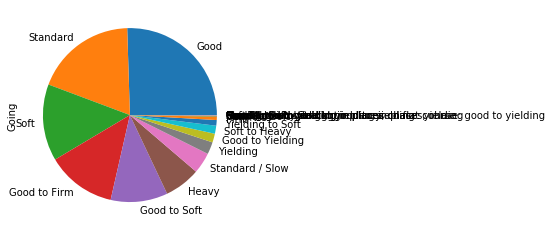

In [73]:
%matplotlib inline
grouped_df['Going'].value_counts(dropna=False).plot(kind='pie')
print(grouped_df['Going'].value_counts(dropna=False))

In [74]:
#Cutting to largest categories which constitute most of the dataset
grouped_df = grouped_df[grouped_df['Going'].isin(grouped_df['Going'].value_counts()[:7].keys())]

## Country

In [75]:
grouped_df['Country'] = grouped_df['Course'].apply(lambda x: country_map(x))

GB     48303
IRE     8479
NI       495
FR       240
UAE       80
GER       18
QA        10
AUS        8
ITY        7
TUR        5
HK         4
SPA        3
CAN        2
SWE        2
KOR        1
BEL        1
SWI        1
NOR        1
Name: Country, dtype: int64


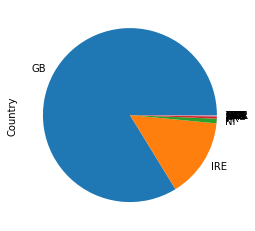

In [76]:
%matplotlib inline
grouped_df['Country'].value_counts(dropna=False).plot(kind='pie')
print(grouped_df['Country'].value_counts(dropna=False))

In [77]:
##Pretty interesting there are no US courses here, given there are a lot of US races listed on Betfair

In [78]:
#Cutting to GB and IRE only
grouped_df = grouped_df[grouped_df['Country'].isin(['GB','IRE'])]

## Courses

In [79]:
grouped_df = grouped_df[grouped_df['Course'].isin(courses_list)]

Wolverhampton        2965
Lingfield            2770
Kempton              2685
Chelmsford City      2144
Newcastle            2114
                     ... 
Kilbeggan (IRE)       176
Bellewstown (IRE)     175
Sligo (IRE)           166
Bangor-On-Dee         160
Laytown (IRE)          24
Name: Course, Length: 85, dtype: int64


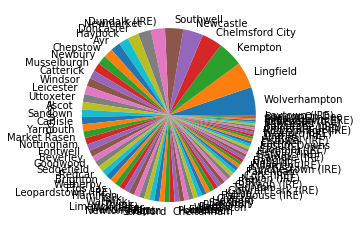

In [80]:
%matplotlib inline
grouped_df['Course'].value_counts(dropna=False).plot(kind='pie')
print(grouped_df['Course'].value_counts(dropna=False))

## Types
### b=flat /  h=hurdle / c = chase

NaN    34816
h      12038
c       8079
b       1849
Name: Type, dtype: int64


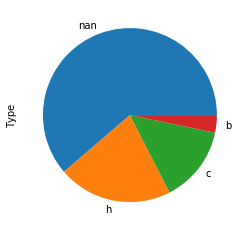

In [81]:
%matplotlib inline
grouped_df['Type'].value_counts(dropna=False).plot(kind='pie')
print(grouped_df['Type'].value_counts(dropna=False))

# Remove handicapping

In [82]:
grouped_df=grouped_df[~grouped_df['Race'].str.contains("andicap")]

NaN    12527
h       5549
c       2182
b       1846
Name: Type, dtype: int64


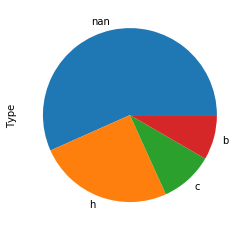

In [83]:
%matplotlib inline
grouped_df['Type'].value_counts(dropna=False).plot(kind='pie')
print(grouped_df['Type'].value_counts(dropna=False))

## Runners

In [96]:
#Interested how often horses typically run in GB & IRE

In [98]:
data['Country'] = data['Course'].apply(lambda x: country_map(x))
data = data[data['Country'].isin(['GB','IRE'])]

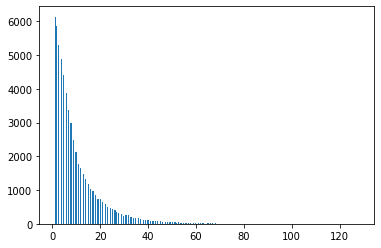

In [103]:
plt.hist(data['HorseName'].value_counts(dropna=False), bins='auto')
plt.show()